# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  








In [14]:
import os
import gensim
import json
import pandas as pd
import numpy as np
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

SEED = 42
np.random.seed(SEED)

In [15]:
def tokenizer(text):
    return [word.strip(punctuation + '«»—…“”*№–') for word in text.lower().split() if word.isalpha()]

In [16]:
class MyModel(nn.Module):
    
    def __init__(self, embed_size, hidden_size, kernels, freeze_param=False, weights=None, num_embeddings=3000000):
        
        super(MyModel, self).__init__()
        if weights is not None: 
            if freeze_param:
                self.embedding = nn.Embedding.from_pretrained(weights, freeze=True)
            elif not freeze_param:
                self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        else:
            self.embedding = nn.Embedding(num_embeddings, embed_size)
            nn.init.uniform_(self.embedding.weight)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])     
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [17]:
def train(model, train_iterator, validation_iterator, optimiser, scheduler, criterion, epochs):
    
    min_loss = np.inf
    no_improv_cnt = 0
    lr_ = []
    train_res = []
    val_res = []
    for epoch in range(epochs):
        loss_list = []
        val_loss_list = []
        
        for batch in train_iterator:         
            optimiser.zero_grad()
            pred = model.forward(batch.text[0])
            loss = criterion(pred, batch.label)
            loss_list.append(loss.item())
            loss.backward()
            optimiser.step()
        
        with tt.no_grad():
            for val_batch in validation_iterator:
                val_pred = model.forward(val_batch.text[0])
                val_loss = criterion(val_pred, val_batch.label)
                val_loss_list.append(val_loss.item())

        train_loss = np.mean(loss_list)
        train_res.append(train_loss)
        val_loss = np.mean(val_loss_list)
        val_res.append(val_loss)
        
        lr_.append(optimiser.param_groups[0]['lr'])
                
        print('|Epoch: {:d}| |Train loss: {:.3f}| Val. loss: {:.3f}| |Lr: {}|'.format(
            epoch, train_loss, val_loss, optimiser.param_groups[0]['lr'])) 
                
        if val_loss < min_loss :
            min_loss = val_loss
            no_improv_cnt = 0
        elif no_improv_cnt < scheduler.patience:
            no_improv_cnt += 1
        else:
            break
            
        scheduler.step(val_loss)    
        
    return model, lr_, train_res, val_res

In [18]:
def test(model, test_iter, criterion):
    model.eval()
    test_res = []
    correct = 0

    with tt.no_grad():
        for batch in test_iter:
            output = model(batch.text[0])
            test_loss = criterion(output, batch.label)
            test_res.append(test_loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch.label.view_as(pred)).sum().item()

    test_loss = np.mean(test_res)
    print('\nTest set: Average loss: {:.3f}'.format(test_loss, correct, len(test_iter.dataset))
    
    return test_loss, correct

In [13]:
df = pd.read_csv('/Users/alinashaymardanova/Downloads/imdb_master.csv', encoding='latin-1', index_col=0)
pd.concat([df[df['type'] == 'train'][:1000],
           df[df['type'] == 'train'][12500:13500],
           df[df['type'] == 'train'][25000:26000]]).to_csv('train.csv', index=False)
pd.concat([df[df['type'] == 'test'][:1000],
           df[df['type'] == 'test'][12500:13500]]).to_csv('test.csv', index=False)

In [19]:
TEXT = Field(include_lengths=True,
         batch_first=True, 
         tokenize=tokenizer,
         eos_token='<eos>',
         lower=True,
         stop_words=stopwords)

classes={'neg': 0, 'unsup': 1, 'pos': 2}
LABEL = LabelField(dtype=tt.int64, 
          use_vocab=True, 
          preprocessing=lambda x: classes[x])

datafields = [("type", None),
          ("text", TEXT),
          ("label", LABEL),
          ("file", None)]

trn = TabularDataset(
        path="train.csv",
        format='csv',
        skip_header=True,
        fields=datafields)

test_set = TabularDataset(
       path="test.csv",
       format='csv',
       skip_header=True,
       fields=datafields)

TEXT.build_vocab(trn, min_freq=5)
LABEL.build_vocab(trn)

train_set, valid = trn.split(0.7, stratified=True)
batch_size = 32
epochs = 10

train_iter, val_iter, test_iter = BucketIterator.splits(
                    (train_set, valid, test_set),
                    batch_sizes=(batch_size, batch_size, batch_size),
                    sort_key=lambda x: len(x.text),
#                         sort_within_batch=False,
                    shuffle=True)

In [12]:
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/alinashaymardanova/Downloads/wiki-news-300d-1M.vec')
weights = tt.FloatTensor(model.vectors)

In [ ]:
freeze_params = [False, True, None]
weights_params = [weights, weights, None]

for i, (freeze_param, weights_param) in enumerate(zip(freeze_params,
                                                      weights_params)):
    tt.cuda.empty_cache()
    model = MyModel(weights=weights_param,
            embed_size=300,
            hidden_size=128,
            kernels=[2,3,4],
            freeze_param=freeze_param)

    criterion = nn.CrossEntropyLoss()

    if not os.path.exists('model{}.pt'.format(i)):

        optimiser = optim.Adam(model.parameters())
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5, verbose=True, cooldown=5)
        model, lr_, train_loss, val_loss = train(model, train_iter, val_iter, optimiser, scheduler, criterion, epochs)
        try:
            tt.save(model.state_dict(),'model{}.pt'.format(i))
        except:
            print('model{}.pt not saved'.format(i))
        
        with open('lr_{}'.format(i), 'w', encoding='utf-8') as fw:
            json.dump(lr_, fw, ensure_ascii=False)
        with open('train_{}'.format(i), 'w', encoding='utf-8') as fw:
            json.dump(train_loss, fw, ensure_ascii=False)
        with open('val_{}'.format(i), 'w', encoding='utf-8') as fw:
            json.dump(val_loss, fw, ensure_ascii=False)

    else:
        model.load_state_dict(tt.load('model{}.pt'.format(i)))

    test_loss, accuracy = test(model, test_iter, criterion)

    with open('test_loss_{}'.format(i), 'w', encoding='utf-8') as fw:
        json.dump(test_loss, fw, ensure_ascii=False)

Learning rate against the number of epoch

In [37]:
def draw(num):
    with open('lr_history_{}'.format(num), 'r') as f:
        lr = json.load(f)   
    plt.plot(range(len(lr)), lr)
    plt.title('Learning rate vs number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()
    
    train = get_values('train_loss', num)
    val = get_values('val_loss', num)
    test = get_values('test_loss', num)
    
    plt.plot(range(len(train)), train, label='train_loss')
    plt.plot(range(len(val)), val, label='val_loss')

    plt.title('Train and Validation losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="best")

def get_values(name, i):
    with open('{}_{}'.format(name, i), 'r') as f:
        values = json.load(f)
    return values    

### 1. Frozen weights.

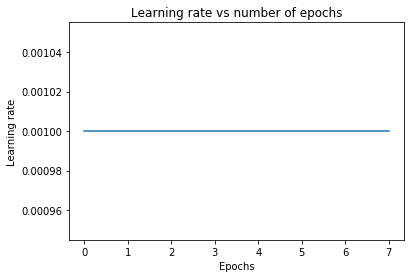

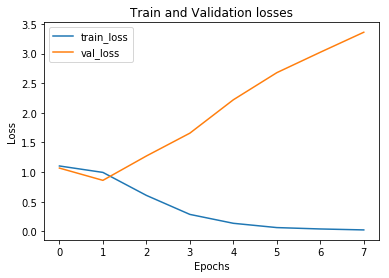

In [38]:
draw(0)

### 2. Initialization from pretrained weights

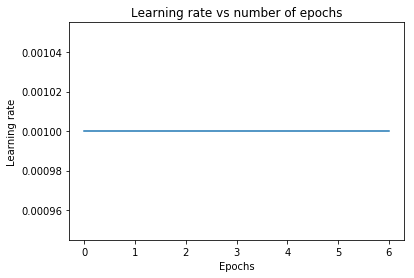

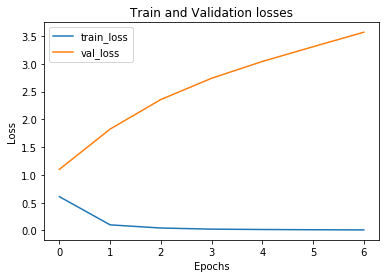

In [39]:
draw(1)

### 3. Random initialization

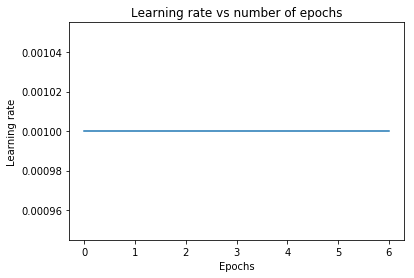

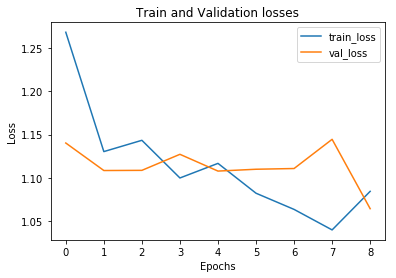

In [40]:
draw(2)

### Validation Curve

In [41]:
train_loss_mean_0 = np.mean(get_values('train_loss', 0))
train_loss_mean_1 = np.mean(get_values('train_loss', 1))
train_loss_mean_2 = np.mean(get_values('train_loss', 2))
train = [train_loss_mean_0, train_loss_mean_1, train_loss_mean_2]

val_loss_mean_0 = np.mean(get_values('val_loss', 0))
val_loss_mean_1 = np.mean(get_values('val_loss', 1))
val_loss_mean_2 = np.mean(get_values('val_loss', 2))
val = [val_loss_mean_0, val_loss_mean_1, val_loss_mean_2]

test_loss_mean_0 = np.mean(get_values('test_loss', 0))
test_loss_mean_1 = np.mean(get_values('test_loss', 1))
test_loss_mean_2 = np.mean(get_values('test_loss', 2))
test = [test_loss_mean_0, test_loss_mean_1, test_loss_mean_2]

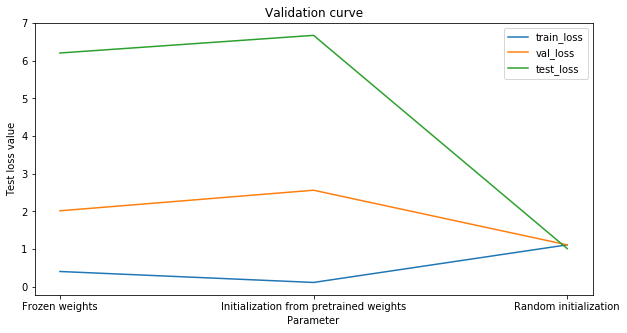

In [50]:
plt.figure(figsize=(10,5)).add_subplot(111)

plt.plot(range(3), train, label='train_loss')
plt.plot(range(3), val, label='val_loss')
plt.plot(range(3), test, label='test_loss')
plt.xticks([0,1,2], ['Frozen weights',
                        'Initialization from pretrained weights',
                        'Random initialization'])
plt.xlabel('Parameter')
plt.ylabel('Test loss value')
plt.title('Validation curve')
plt.legend(loc="best")